In [70]:
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from gudhi.wasserstein import wasserstein_distance
import gudhi.representations
import math
from sklearn.metrics.pairwise import euclidean_distances
from tabulate import tabulate
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import matplotlib.colors as mcolors
from copy import deepcopy
from gudhi.representations import Landscape, PersistenceImage

from topofisher.input_simulators.noisy_ring import CircleSimulator

from topofisher.filtrations.numpy.alphaDTML import AlphaDTMLayer
from topofisher.filtrations.numpy.default_filtrations import RipsFiltration

from topofisher.vectorizations.numpy.custom_vectorizations import TOPK
from topofisher.vectorizations.numpy.vectorization_layer import VectorizationLayers
from topofisher.vectorizations.numpy.shorthand_layers import PersistenceImages, PersistenceLandscapes

from topofisher.fisher.Fisher import show_fm_and_bias, fisherFromVecs, fisherMOPED
from topofisher.fisher.imnn import IMNNLayer, MopedLayer, ExtraDimLayer
from topofisher.fisher.plot_fisher_stats import plotContours2D, plotSummaryDerivativeHists, plot_derivative_convergence


from topofisher.pipelines.circle import CirclePipeline
from topofisher.pipelines.convergence_checks import fisher_estimates_wrt_step_size
from topofisher.pipelines.utils import readFromFile, writeToFile
import random

In [121]:
grfs = []
for idx in range(10):
    grf = np.loadtxt("grfs/{}_reduced.txt".format(idx))

    grfs.append(grf[random.sample(list(range(len(grf))), 500)])
    

In [122]:
[len(grf) for grf in grfs]

[500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

100%|██████████| 10/10 [00:13<00:00,  1.39s/it]


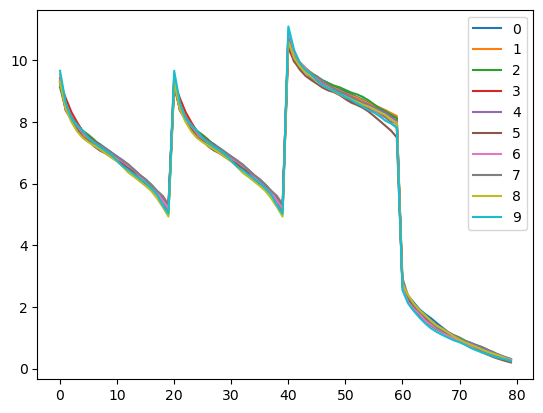

In [124]:
vectorizations = [TOPK(bdp_type = "dp", is_binned = True, num_bins = 20) for _ in range(2)]
vecLayer = VectorizationLayers(vectorizations = vectorizations)
vecs = vecLayer.vectorize_persistence_diagrams(pds)
for idx in range(10) : plt.plot(vecs[idx], label = idx)
plt.legend()

In [130]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
# Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(vecs)
print(cosine_sim_matrix.shape)

# Calculate the average cosine similarity for each vector
average_similarity = np.mean(cosine_sim_matrix, axis=1)

# Find the index of the vector with the lowest average similarity
odd_one_out_index = np.argmin(average_similarity)

# Print the vector that is the odd one out
odd_one_out = vecs[odd_one_out_index]
print("Odd one out vector:", odd_one_out_index)







(10, 10)
Odd one out vector: 9


In [126]:
print(np.argsort(average_similarity))

[9 3 5 2 8 7 1 0 4 6]


In [127]:
average_similarity

array([0.99990189, 0.99989936, 0.9998753 , 0.99985957, 0.99990864,
       0.99986211, 0.99991792, 0.99989521, 0.99988234, 0.99981009])

In [128]:
len(pds)

2

In [185]:
def run_sim(num_pts):
    grfs = []
    for idx in range(10):
        grf = np.loadtxt("grfs/{}_reduced.txt".format(idx))

        grfs.append(grf[random.sample(list(range(len(grf))), num_pts)])

    filtLayer = RipsFiltration(collapse_edges = True, max_hom_dim = 2, hom_dim_list = list(range(2)), show_tqdm = False)
    pds = filtLayer.find_persistence_diagrams(grfs) 
    PE = gd.representations.Entropy()
    pe = np.hstack([PE.fit_transform(pds[0]), PE.fit_transform(pds[1])])
    return pe
pes = [run_sim(400) for _ in tqdm(range(20))]

100%|██████████| 20/20 [02:22<00:00,  7.11s/it]


In [186]:
pes = np.array(pes)

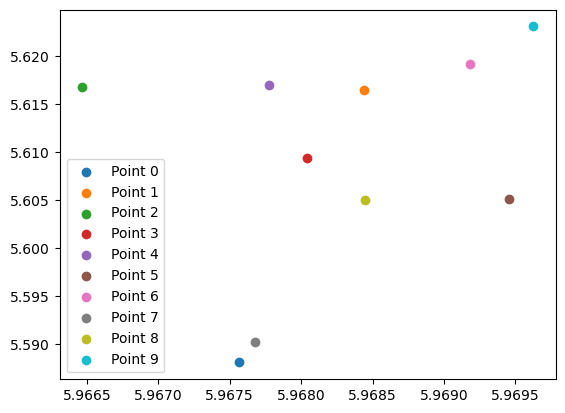

In [187]:
pe_m = pes.mean(axis = 0)
for i, (x_val, y_val) in enumerate(pe_m):
    plt.scatter(x_val, y_val, label=f'Point {i}')

# Add legend
plt.legend()

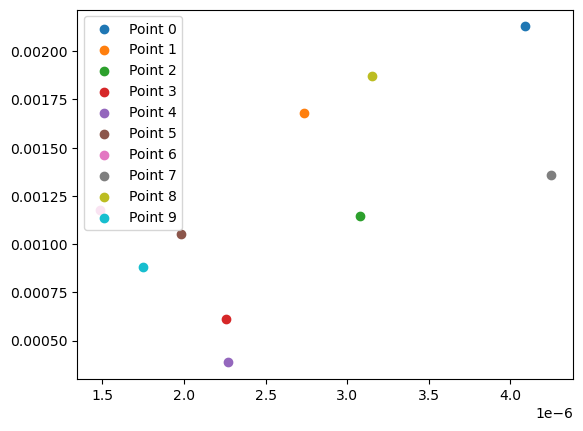

In [188]:
pe_m = pes.var(axis = 0)
for i, (x_val, y_val) in enumerate(pe_m):
    plt.scatter(x_val, y_val, label=f'Point {i}')

# Add legend
plt.legend()

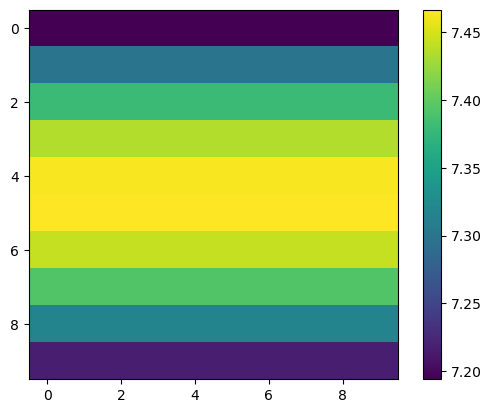

In [180]:
res = 10
bandwidths = [1., 1.]
vectorizations = [PersistenceImage(
                bandwidth = bandwidths[0], resolution = [res, res], weight = lambda x: x[1]**2), 
                  PersistenceImage( bandwidth = bandwidths[1], resolution = [res, res], \
                    weight = lambda x: 1)]
pi_vec_layer = VectorizationLayers(vectorizations = vectorizations)
pis = pi_vec_layer.vectorize_persistence_diagrams(pds)
#pis = np.array(pis)
#pis = np.reshape(pis, (10, res, res, 2))
plt.imshow(np.flip(np.reshape(pis[3, :res*res], (res,res)), axis = 0))
plt.colorbar()

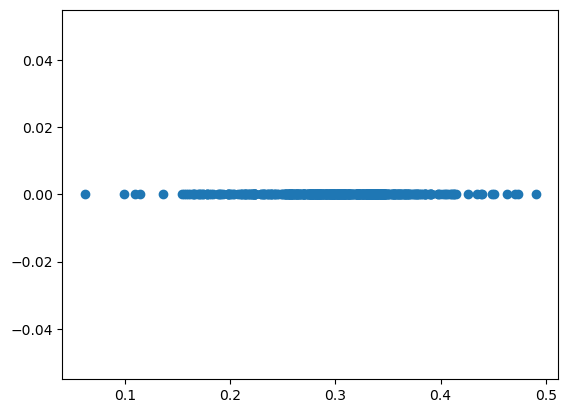

In [184]:
w = pds[0][0]
plt.scatter(w[:, 1] - w[:, 0], w[:, 0])